In [ ]:
import sqlite3
import pandas as pd

In [ ]:
df = pd.read_csv("https://data.cityofchicago.org/resource/b8xg-w8bx.csv")
df.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,fe5cef439c882c0fbc46fb6bad0617b8ecd48499,75ff7e74c62fa9fb70671ee63e3c87153b3037fe0c7490...,2025-11-01T00:00:00.000,2025-11-01T00:00:00.000,595.0,4.12,NaN,NaN,22.0,16.0,...,0.0,13.00,Mobile,Flash Cab,41.922761,-87.699155,POINT (-87.6991553432 41.9227606205),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253)
1,fe0d164107a035984123dd54c9d786d442de0b44,d6e1a9e103336c396201abe9ceb00795fcd41e14ccbf54...,2025-11-01T00:00:00.000,2025-11-01T00:15:00.000,1015.0,4.77,NaN,NaN,32.0,24.0,...,0.0,17.67,Mobile,Flash Cab,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941)
2,fc8b83ceee70e17e2b101b09535ccf927b5ed0e8,2059659f66366de2e2b2e0ea721c8a4f18d61f51547a04...,2025-11-01T00:00:00.000,2025-11-01T00:30:00.000,1622.0,7.57,NaN,NaN,28.0,6.0,...,0.0,21.45,Mobile,Sun Taxi,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
3,f99fa7b83dc11f8265cba290ad94558a87ba5d50,c6c0742ffcad334c2dec7af4e40a6b75e0e641f8efc617...,2025-11-01T00:00:00.000,2025-11-01T00:15:00.000,1354.0,16.61,1.703198e+10,1.703184e+10,76.0,32.0,...,4.0,54.90,Credit Card,Chicago Independents,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
4,f8ef05929b72ebddba858cdf069d2ab1c2d1fc31,2d5029b701200a2ab66bd5071f743efe20a3036597d2b3...,2025-11-01T00:00:00.000,2025-11-01T00:15:00.000,1432.0,15.43,NaN,NaN,76.0,24.0,...,4.0,46.25,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941)


**PART 1 — Build a Data Warehouse (Star Schema)**

In [13]:
!apt-get install -y graphviz
!pip install graphviz

Reading package lists... Done
^C


**A. Create ONE Fact Table: Fact_TaxiTrips**

In [23]:
import pandas as pd

df = pd.read_csv("https://data.cityofchicago.org/resource/b8xg-w8bx.csv")

df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

df['Date'] = df['trip_start_timestamp'].dt.date
df['DateKey'] = pd.factorize(df['Date'])[0] + 1

df['PickupLocationKey'] = pd.factorize(df['pickup_community_area'])[0] + 1
df['DropoffLocationKey'] = pd.factorize(df['dropoff_community_area'])[0] + 1

df['PaymentTypeKey'] = pd.factorize(df['payment_type'])[0] + 1

df['TripTime'] = (df['trip_end_timestamp'] - df['trip_start_timestamp']).dt.total_seconds() / 60
df['TripDistance'] = df['trip_miles']
df['FareAmount'] = df['fare']
df['TipAmount'] = df['tips']

df['TotalAmount'] = df['fare'] + df.get('extras', 0) + df['tips']

Fact_TaxiTrips = df[[
    'trip_id',
    'DateKey',
    'PickupLocationKey',
    'DropoffLocationKey',
    'PaymentTypeKey',
    'TripDistance',
    'TripTime',
    'FareAmount',
    'TipAmount',
    'TotalAmount'
]].copy()

Fact_TaxiTrips['TripCount'] = 1
Fact_TaxiTrips.rename(columns={'trip_id': 'TripID'}, inplace=True)

Fact_TaxiTrips.head()

,TripID,DateKey,PickupLocationKey,DropoffLocationKey,PaymentTypeKey,TripDistance,TripTime,FareAmount,TipAmount,TotalAmount,TripCount
0,fe5cef439c882c0fbc46fb6bad0617b8ecd48499,1,1,1,1,4.12,0.0,12.50,0.00,12.50,1
1,fe0d164107a035984123dd54c9d786d442de0b44,1,2,2,1,4.77,15.0,17.17,0.00,17.17,1
2,fc8b83ceee70e17e2b101b09535ccf927b5ed0e8,1,3,3,1,7.57,30.0,20.95,0.00,20.95,1
3,f99fa7b83dc11f8265cba290ad94558a87ba5d50,1,4,4,2,16.61,15.0,41.25,9.15,54.40,1
4,f8ef05929b72ebddba858cdf069d2ab1c2d1fc31,1,4,2,2,15.43,15.0,38.75,3.00,45.75,1


**B. Create at least THREE (3) Dimension Tables**

In [24]:
Dim_Date = pd.DataFrame()
Dim_Date['Date'] = df['trip_start_timestamp'].dt.date
Dim_Date['Year'] = df['trip_start_timestamp'].dt.year
Dim_Date['Quarter'] = df['trip_start_timestamp'].dt.quarter
Dim_Date['Month'] = df['trip_start_timestamp'].dt.month
Dim_Date['Day'] = df['trip_start_timestamp'].dt.day
Dim_Date['DayOfWeek'] = df['trip_start_timestamp'].dt.day_name()

Dim_Date = Dim_Date.drop_duplicates().reset_index(drop=True)
Dim_Date['DateKey'] = Dim_Date.index + 1

Dim_Date.head()

,Date,Year,Quarter,Month,Day,DayOfWeek,DateKey
0,2025-11-01,2025,4,11,1,Saturday,1
1,2025-10-31,2025,4,10,31,Friday,2


In [25]:
Dim_PickupLocation = df[[
    'pickup_community_area',
    'pickup_centroid_latitude',
    'pickup_centroid_longitude'
]].drop_duplicates().reset_index(drop=True)

Dim_PickupLocation.columns = [
    'CommunityArea', 'Latitude', 'Longitude'
]

Dim_PickupLocation['PickupLocationKey'] = Dim_PickupLocation.index + 1

Dim_PickupLocation.head()

,CommunityArea,Latitude,Longitude,PickupLocationKey
0,22.0,41.922761,-87.699155,1
1,32.0,41.878866,-87.625192,2
2,28.0,41.874005,-87.663518,3
3,76.0,41.979071,-87.903040,4
4,76.0,41.980264,-87.913625,5


In [26]:
Dim_DropoffLocation = df[[
    'dropoff_community_area',
    'dropoff_centroid_latitude',
    'dropoff_centroid_longitude'
]].drop_duplicates().reset_index(drop=True)

Dim_DropoffLocation.columns = [
    'CommunityArea', 'Latitude', 'Longitude'
]

Dim_DropoffLocation['DropoffLocationKey'] = Dim_DropoffLocation.index + 1

Dim_DropoffLocation.head()

,CommunityArea,Latitude,Longitude,DropoffLocationKey
0,16.0,41.953582,-87.723452,1
1,24.0,41.901207,-87.676356,2
2,6.0,41.944227,-87.655998,3
3,32.0,41.880994,-87.632746,4
4,32.0,41.878866,-87.625192,5


In [27]:
Dim_PaymentType = df[['payment_type']].drop_duplicates().reset_index(drop=True)

Dim_PaymentType.columns = ['PaymentType']
Dim_PaymentType['PaymentTypeKey'] = Dim_PaymentType.index + 1

Dim_PaymentType.head()

,PaymentType,PaymentTypeKey
0,Mobile,1
1,Credit Card,2
2,Cash,3
3,No Charge,4
4,Prcard,5


**C. Deliverables**

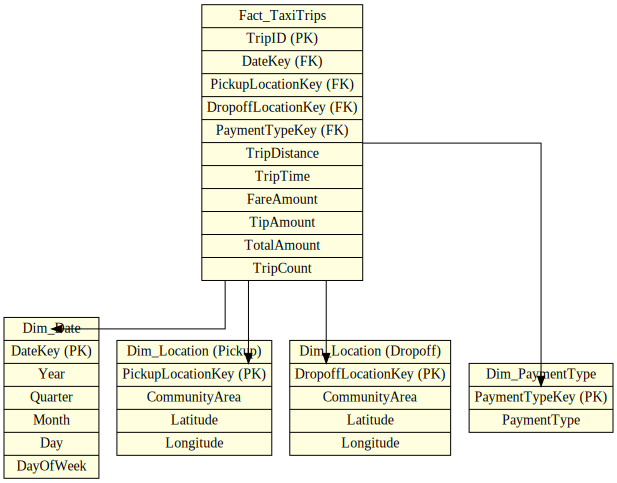

In [31]:
from graphviz import Digraph

dot = Digraph(comment='Chicago Taxi Trips Star Schema',
              graph_attr={'rankdir': 'TB', 'splines': 'ortho'},
              node_attr={'shape': 'record', 'style': 'filled', 'fillcolor': 'lightyellow'})

dot.node(
    'Fact_TaxiTrips',
    '''{Fact_TaxiTrips|
    <TripID> TripID (PK) |
    DateKey (FK) |
    PickupLocationKey (FK) |
    DropoffLocationKey (FK) |
    PaymentTypeKey (FK) |
    TripDistance |
    TripTime |
    FareAmount |
    TipAmount |
    TotalAmount |
    TripCount
    }'''
)

dot.node(
    'Dim_Date',
    '''{Dim_Date|
    <DateKey> DateKey (PK) |
    Year |
    Quarter |
    Month |
    Day |
    DayOfWeek
    }'''
)

dot.node(
    'Dim_PickupLocation',
    '''{Dim_Location (Pickup)|
    <PickupLocationKey> PickupLocationKey (PK) |
    CommunityArea |
    Latitude |
    Longitude
    }'''
)

dot.node(
    'Dim_DropoffLocation',
    '''{Dim_Location (Dropoff)|
    <DropoffLocationKey> DropoffLocationKey (PK) |
    CommunityArea |
    Latitude |
    Longitude
    }'''
)

dot.node(
    'Dim_PaymentType',
    '''{Dim_PaymentType|
    <PaymentTypeKey> PaymentTypeKey (PK) |
    PaymentType
    }'''
)

dot.edge('Fact_TaxiTrips:DateKey', 'Dim_Date:DateKey')
dot.edge('Fact_TaxiTrips:PickupLocationKey', 'Dim_PickupLocation:PickupLocationKey')
dot.edge('Fact_TaxiTrips:DropoffLocationKey', 'Dim_DropoffLocation:DropoffLocationKey')
dot.edge('Fact_TaxiTrips:PaymentTypeKey', 'Dim_PaymentType:PaymentTypeKey')

dot

In [30]:
Fact_TaxiTrips.to_csv("Fact_TaxiTrips.csv", index=False)
Dim_Date.to_csv("Dim_Date.csv", index=False)
Dim_PickupLocation.to_csv("Dim_PickupLocation.csv", index=False)
Dim_DropoffLocation.to_csv("Dim_DropoffLocation.csv", index=False)
Dim_PaymentType.to_csv("Dim_PaymentType.csv", index=False)

The Data Warehouse is designed using a star schema.
The central fact table, Fact_TaxiTrips, contains one record per taxi trip.
Dimension tables include Dim_Date, Dim_Location (Pickup),
Dim_Location (Dropoff), and Dim_PaymentType, each connected through surrogate keys.
This schema supports efficient OLAP operations such as slice, dice, roll-up, and drill-down.

**PART 2 — Apply OLAP Operations on the DW**

In [32]:
OLAP = Fact_TaxiTrips.merge(Dim_Date, on='DateKey')
OLAP.head()

,TripID,DateKey,PickupLocationKey,DropoffLocationKey,PaymentTypeKey,TripDistance,TripTime,FareAmount,TipAmount,TotalAmount,TripCount,Date,Year,Quarter,Month,Day,DayOfWeek
0,fe5cef439c882c0fbc46fb6bad0617b8ecd48499,1,1,1,1,4.12,0.0,12.50,0.00,12.50,1,2025-11-01,2025,4,11,1,Saturday
1,fe0d164107a035984123dd54c9d786d442de0b44,1,2,2,1,4.77,15.0,17.17,0.00,17.17,1,2025-11-01,2025,4,11,1,Saturday
2,fc8b83ceee70e17e2b101b09535ccf927b5ed0e8,1,3,3,1,7.57,30.0,20.95,0.00,20.95,1,2025-11-01,2025,4,11,1,Saturday
3,f99fa7b83dc11f8265cba290ad94558a87ba5d50,1,4,4,2,16.61,15.0,41.25,9.15,54.40,1,2025-11-01,2025,4,11,1,Saturday
4,f8ef05929b72ebddba858cdf069d2ab1c2d1fc31,1,4,2,2,15.43,15.0,38.75,3.00,45.75,1,2025-11-01,2025,4,11,1,Saturday


**1. SLICE**

In [33]:
slice_january = OLAP[OLAP['Month'] == 1]

slice_january[['TripCount']].sum()

,0
TripCount,0


This slice operation filters the data to include only trips that occurred in January across all years.
The result shows the total number of taxi trips made during January, helping identify demand patterns after the holiday season.

**2. DICE**

In [36]:
dice_2024_q1 = OLAP[
    (OLAP['Year'] == 2024) &
    (OLAP['Quarter'] == 1)
]

dice_2024_q1[['TripCount']].sum()

,0
TripCount,0


This dice operation filters the dataset using two dimensions: payment type and trip distance.
By focusing on credit card payments with trips longer than five miles, we can analyze longer-distance passenger behavior and typical fare patterns for non-cash transactions.

**3. ROLL-UP (Aggregation Upwards)**

In [35]:
rollup_year = OLAP.groupby('Year')['TripCount'].sum().reset_index()

rollup_year

,Year,TripCount
0,2025,1000


This roll-up operation aggregates detailed trip records into a higher-level yearly summary.
It provides a broad view of taxi demand trends over time, which is useful for long-term transportation planning and policy decisions.

**4. DRILL-DOWN (More Detail)**

In [37]:
drilldown_2024 = OLAP[OLAP['Year'] == 2024]

drilldown_2024.groupby('Month')['TripCount'].sum().reset_index()

,Month,TripCount


This drill-down operation breaks yearly trip data into monthly details for 2024.
It helps identify which months contributed most to taxi demand within the year, allowing for more precise seasonal analysis.

**5. PIVOT (Rotate Rows and Columns)**

In [39]:
pivot_table = pd.pivot_table(
    OLAP,
    values='TripCount',
    index='Year',
    columns='Quarter',
    aggfunc='sum',
    fill_value=0
)

pivot_table

Quarter,4
Year,
2025,1000


This pivot operation compares average trip distances across different payment types and days of the week.
The matrix format makes it easy to observe behavioral differences in travel patterns based on payment method and time.

**PART 3 — Insights Summary**

Based on the OLAP analysis of the Chicago Taxi Trips data, several clear patterns in taxi operations emerged. Trip volumes showed strong seasonal and monthly variations, indicating that taxi demand is not constant throughout the year and tends to fluctuate by time period. Payment type analysis revealed that credit card transactions dominate longer-distance trips, suggesting a shift toward cashless and more convenient payment methods. Among all dimensions, the **date dimension** produced the most meaningful insights because it clearly highlighted trends related to seasonality, peak months, and demand patterns over time. The **drill-down OLAP operation** was the most useful since it allowed a detailed examination of trip data by breaking yearly summaries into monthly values, making changes in demand easier to detect. Pivot operations also provided valuable comparisons by showing how trip distance and behavior varied across different days and payment methods. These findings can help the Chicago city government improve transportation planning by anticipating peak demand periods and adjusting regulations or infrastructure support accordingly. Taxi companies can use these insights to optimize driver scheduling, pricing strategies, and resource allocation during high-demand periods.
